<a href="https://colab.research.google.com/github/emilyhoughkovacs/splice/blob/main/logisitic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data
The following three sections are part of the cookiecutter provided out-of-the-box when exporting data from BigQuery to a python notebook. Jump to "Prepare data to be ready to use in model" for my analysis.

In [3]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'emily-hk' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=emily-hk:US:bquxjob_5306aba3_18de268c6c3)
back to BigQuery to edit the query within the BigQuery user interface.

In [4]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_5306aba3_18de268c6c3') # Job ID inserted based on the query results selected to explore
print(job.query)

with browsers as (SELECT 
  device.browser,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
group by 1
order by 2 desc
limit 3),
oses as (SELECT 
  device.operatingSystem,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
group by 1
order by 2 desc
limit 5),
countries as (SELECT 
  geoNetwork.country,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
group by 1
order by 2 desc
LIMIT 10),
lp as (SELECT 
  if(h.page.pagePath LIKE '/google+redesign/apparel%', '/google+redesign/apparel', h.page.pagePath) as landing_page,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, unnest(hits) h
where isEntrance is true
group by 1
order by 2 desc
LIMIT 5
),
visits_landing_page as (SELECT
  CONCAT(fullVisitorId, "-", visitId, "-", date) as unique_session_id,
  if(h.page.pagePath LIKE '/google+redesign/apparel%', '/google+redesign/apparel', h.page.pagePath) as landing_page
  FROM `bigquery-pub

## Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [5]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_5306aba3_18de268c6c3') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,unique_session_id,hits,pageviews,medium,browser,operatingSystem,country,landing_page,is_transaction
0,8597222891158829963-1477761593-20161029,53,33,(none),Safari,iOS,United States,Other,0
1,847183914353283820-1474211709-20160918,22,20,organic,Chrome,Other,Other,/home,0
2,6408592838060313017-1471536336-20160818,94,64,(none),Chrome,Windows,United States,/home,1
3,0689482657554164004-1500638351-20170721,35,28,organic,Chrome,Android,Other,/home,0
4,3098102694893246712-1498839677-20170630,52,36,organic,Other,Windows,United States,/google+redesign/apparel,1
...,...,...,...,...,...,...,...,...,...
903548,2401141511008437892-1486135052-20170203,16,13,(none),Chrome,Macintosh,United States,/google+redesign/apparel,0
903549,9148627782134822389-1485327977-20170124,16,12,cpm,Chrome,Macintosh,United States,/home,0
903550,0066593530542228662-1484061450-20170110,16,15,(none),Chrome,Macintosh,United States,/home,0
903551,5483474169242977077-1486122335-20170203,16,16,(none),Chrome,Android,United States,/home,0


# Prepare data to be ready to use in model

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
df = results.drop('unique_session_id', axis=1)

In [8]:
df.shape

(903553, 8)

In [9]:
y= df['is_transaction']
X= df.drop(['is_transaction'], axis=1)

In [10]:
X.dtypes

hits                Int64
pageviews           Int64
medium             object
browser            object
operatingSystem    object
country            object
landing_page       object
dtype: object

## Visualize and preprocess numerical features
We want to see the distribution of `hits` and `pageviews`. Then we'll normalize them between 0-1 up to 1 SD and assign all outliers a value of 1, so that the range of these numerical values are between 0 and 1. This way they'll be comparable to our categorical variables which we will one-hot encode.

In [11]:
avg_pageviews = np.mean(X['pageviews'])
avg_hits = np.mean(X['hits'])

std_pageviews = np.std(X['pageviews'])
std_hits = np.std(X['hits'])

In [12]:
import matplotlib.pyplot as plt

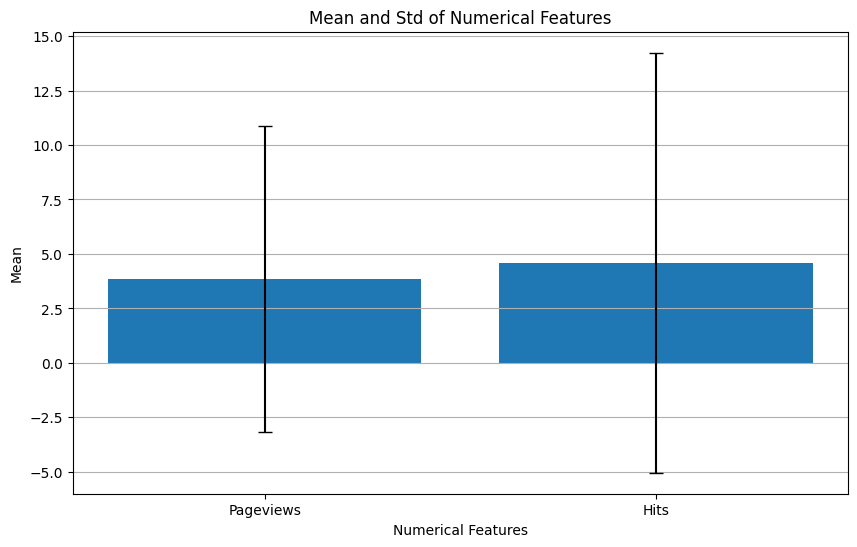

In [13]:
# Plot the datasets
plt.figure(figsize=(10, 6))
plt.bar([1, 2], [avg_pageviews, avg_hits], yerr=[std_pageviews, std_hits], tick_label=['Pageviews', 'Hits'], capsize=5)
plt.xlabel('Numerical Features')
plt.ylabel('Mean')
plt.title('Mean and Std of Numerical Features')
plt.grid(axis='y')
plt.show()

In [14]:
# Normalize between 0 and these values. any values above these, convert to 1.
one_std_pageviews = np.floor(avg_pageviews + std_pageviews)
one_std_hits = np.floor(avg_hits + std_hits)

In [15]:
min_pvs = X['pageviews'].min()
min_hits = X['hits'].min()

X['normalized_pvs'] = (X['pageviews']-min_pvs)/(one_std_pageviews - min_pvs)
X['normalized_hits'] = (X['hits']-min_hits)/(one_std_hits - min_hits)

In [16]:
X[['normalized_pvs', 'normalized_hits']].describe()

,normalized_pvs,normalized_hits
count,903553.0,903553.0
mean,0.31664,0.276682
std,0.780586,0.741685
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.076923
75%,0.333333,0.230769
max,52.0,38.384615


In [17]:
X.loc[X['normalized_pvs'] > 1, 'normalized_pvs'] = 1
X.loc[X['normalized_hits'] > 1, 'normalized_hits'] = 1

In [18]:
X[['normalized_pvs', 'normalized_hits']].describe()

,normalized_pvs,normalized_hits
count,903553.0,903553.0
mean,0.215662,0.189698
std,0.321302,0.302998
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.076923
75%,0.333333,0.230769
max,1.0,1.0


## One-hot encode categorical variables
In order for the model to understand categorical variables, we need to convert them to numbers. One option is to assign a value for each category, for instance for `country`, United States = 1, Canada = 2 and so on. But this implies an inherent ordering that might not exist, so instead we will one-hot encode.

In [19]:
X_onehot = pd.get_dummies(X[['medium', 'browser', 'operatingSystem', 'country', 'landing_page']])

In [20]:
X_onehot.dtypes

medium_(none)                                          uint8
medium_(not set)                                       uint8
medium_affiliate                                       uint8
medium_cpc                                             uint8
medium_cpm                                             uint8
medium_organic                                         uint8
medium_referral                                        uint8
browser_Chrome                                         uint8
browser_Firefox                                        uint8
browser_Other                                          uint8
browser_Safari                                         uint8
operatingSystem_Android                                uint8
operatingSystem_Linux                                  uint8
operatingSystem_Macintosh                              uint8
operatingSystem_Other                                  uint8
operatingSystem_Windows                                uint8
operatingSystem_iOS     

In [21]:
X_onehot = X_onehot.drop(['medium_(not set)', 'browser_Other', 'operatingSystem_Other', 'country_Other', 'landing_page_Other'], axis=1)

In [22]:
X_encoded = pd.concat([X[['normalized_pvs', 'normalized_hits']], X_onehot], axis=1)

In [23]:
X_encoded.describe()

,normalized_pvs,normalized_hits,medium_(none),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,browser_Chrome,browser_Firefox,...,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_Vietnam,landing_page_/basket.html,landing_page_/google+redesign/apparel,landing_page_/google+redesign/shop+by+brand/youtube,landing_page_/home,landing_page_/signin.html
count,903553.0,903553.0,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000,903553.00000,903553.000000,...,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000,903553.000000
mean,0.215662,0.189698,0.411063,0.018152,0.014474,0.006844,0.259373,0.289965,0.68649,0.041020,...,0.022271,0.022713,0.041380,0.403625,0.027221,0.011034,0.087239,0.090290,0.681995,0.018073
std,0.321302,0.302998,0.492027,0.133500,0.119434,0.082445,0.438291,0.453746,0.46392,0.198337,...,0.147564,0.148986,0.199168,0.490624,0.162728,0.104463,0.282185,0.286597,0.465702,0.133216
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.333333,0.230769,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
X_encoded.shape

(903553, 31)

In [25]:
y.shape

(903553,)

## Scale all features

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [28]:
pd.DataFrame(X_scaled, columns=X_encoded.columns).describe()

,normalized_pvs,normalized_hits,medium_(none),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,browser_Chrome,browser_Firefox,...,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_Vietnam,landing_page_/basket.html,landing_page_/google+redesign/apparel,landing_page_/google+redesign/shop+by+brand/youtube,landing_page_/home,landing_page_/signin.html
count,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,...,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05,9.035530e+05
mean,4.227619e-17,2.234599e-16,-1.706146e-16,-7.146689e-17,3.507288e-17,4.576775e-17,2.755502e-17,-6.240771e-17,-6.140113e-17,-1.146553e-16,...,-2.327707e-18,-3.963393e-18,-9.921064e-17,-2.189303e-17,-3.478978e-17,1.868457e-17,-1.522446e-17,-5.177575e-17,-5.369453e-17,7.060186e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-6.712139e-01,-6.260701e-01,-8.354483e-01,-1.359678e-01,-1.211881e-01,-8.301359e-02,-5.917827e-01,-6.390476e-01,-1.479760e+00,-2.068210e-01,...,-1.509247e-01,-1.524480e-01,-2.077647e-01,-8.226777e-01,-1.672817e-01,-1.056283e-01,-3.091552e-01,-3.150423e-01,-1.464448e+00,-1.356678e-01
25%,-6.712139e-01,-6.260701e-01,-8.354483e-01,-1.359678e-01,-1.211881e-01,-8.301359e-02,-5.917827e-01,-6.390476e-01,-1.479760e+00,-2.068210e-01,...,-1.509247e-01,-1.524480e-01,-2.077647e-01,-8.226777e-01,-1.672817e-01,-1.056283e-01,-3.091552e-01,-3.150423e-01,-1.464448e+00,-1.356678e-01
50%,-6.712139e-01,-3.721967e-01,-8.354483e-01,-1.359678e-01,-1.211881e-01,-8.301359e-02,-5.917827e-01,-6.390476e-01,6.757852e-01,-2.068210e-01,...,-1.509247e-01,-1.524480e-01,-2.077647e-01,-8.226777e-01,-1.672817e-01,-1.056283e-01,-3.091552e-01,-3.150423e-01,6.828510e-01,-1.356678e-01
75%,3.662337e-01,1.355500e-01,1.196962e+00,-1.359678e-01,-1.211881e-01,-8.301359e-02,1.689809e+00,1.564829e+00,6.757852e-01,-2.068210e-01,...,-1.509247e-01,-1.524480e-01,-2.077647e-01,1.215543e+00,-1.672817e-01,-1.056283e-01,-3.091552e-01,-3.150423e-01,6.828510e-01,-1.356678e-01
max,2.441129e+00,2.674284e+00,1.196962e+00,7.354681e+00,8.251639e+00,1.204622e+01,1.689809e+00,1.564829e+00,6.757852e-01,4.835099e+00,...,6.625821e+00,6.559612e+00,4.813136e+00,1.215543e+00,5.977940e+00,9.467163e+00,3.234621e+00,3.174177e+00,6.828510e-01,7.370947e+00


# Set up and train logistic regression
This will give us feature importances for each of our variables.

In [38]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=13)

In [40]:
# Instantiate the model, set max_iter=1000 so the model can converge
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Investigate feature importances

In [47]:
# Get feature importance
feature_importance = log_reg.coef_[0]

# Map feature importance to column names
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importance})

# Get absolute value of feature importance
feature_importance_df['Importance_abs'] = np.abs(feature_importance_df['Importance'])

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance_abs', ascending=False)

# Print or visualize feature importance
print(feature_importance_df[['Feature', 'Importance']])

                                              Feature  Importance
0                                      normalized_pvs    2.814422
1                                     normalized_hits    1.499064
24                              country_United States    1.163139
25                                    country_Vietnam   -0.516070
11                            operatingSystem_Android   -0.380130
19                                      country_India   -0.294164
29                                 landing_page_/home   -0.265212
15                                operatingSystem_iOS   -0.255502
23                             country_United Kingdom   -0.232931
22                                     country_Turkey   -0.208161
17                                     country_Canada    0.184005
14                            operatingSystem_Windows   -0.180313
2                                       medium_(none)    0.175307
7                                     medium_referral   -0.165837
3         